### Choosing final clusters

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle as pk
import pandas as pd
import numpy as np
import wandb
from itertools import combinations
import networkx as nx
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_samples, silhouette_score

from utilities import run_configs, load_symptom_data, modularity, clustering_similarity

%matplotlib inline

In [4]:
tessa_clusters = pd.read_csv('../clusterings/tessa/cluster_13_111023.csv', index_col=0)

In [5]:
SEARCH_TYPE = 'randomized_search'  # we want random parameterisations for diversity.
SAMPLE_SIZE = 200  # number of sample to take from each pipeline to build library 
RUN_IDS_TO_INCLUDE = [1, 2, 5, 6]  # we will reproduce using only kmeans (and including p-umap)
NMI_SCORE = 'mi'  # arg to pass to clustering_similarity method to use partial NMI (ignoring -1 labels from hdbscan) 
SEED = 42
IGNORE_LABEL = None
LINKAGE_METHOD = 'average'


In [6]:
np.random.seed(SEED)

In [7]:
run_metadata = {
    'randomized_search': {
        1: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/ndz8b3cz',
            'results_path': 'results/umap_kmeans_silhouette_run_10/all_results.pickle'
        },
        2: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/gcnqmv1k',
            'results_path': 'results/umap_kmeans_dbcv_run_11/all_results.pickle'
        },
        3: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/t0tzp4gz',
            'results_path': 'results/umap_hdbscan_silhouette_run_10/all_results.pickle'
        },
        4: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/zgsa9yi4',
            'results_path': 'results/umap_hdbscan_dbcv_run_11/all_results.pickle'
        },
        5: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/x42hq5ez',
            'results_path': 'results/pca_kmeans_silhouette_run_10/all_results.pickle'
        },
        6: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/qgy8ifuf',
            'results_path': 'results/pca_kmeans_dbcv_run_10/all_results.pickle'
        },
        7: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/en968oqc',
            'results_path': 'results/pca_hdbscan_silhouette_run_10/all_results.pickle'
        },
        8: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/ocncbqca',
            'results_path': 'results/pca_hdbscan_dbcv_run_10/all_results.pickle'
        },
        13: {
            'run_path': 'rusty-chris/tune_shallow_clustering/runs/lo5r07or',
            'results_path': 'results/parametric_umap_kmeans_silhouette_run_10/all_results.pickle'
        },
        15: {
            'run_path': 'rusty-chris/tune_shallow_clustering/tv9hnbnn',
            'results_path': 'results/parametric_umap_hdbscan_silhouette_run_10/all_results.pickle'
        }
    }
}

#### First we assemble our library of clusterings by selecting from the prior optimisation runs.

In [8]:
symptom_data = load_symptom_data(run_configs[1]['data_path'])

In [7]:
for key in run_metadata[SEARCH_TYPE].keys():
    run_configs[key].update(run_metadata[SEARCH_TYPE][key])

In [8]:
def load_results(run_id):
    run_config = run_configs[run_id]
    with open(run_config['results_path'], 'rb') as outfile:
        results = pk.load(outfile)
        
    results = pd.DataFrame.from_dict(results, orient='index')
    results['original_index'] = results.index
    results['run_id'] = run_id
    return results

In [9]:
all_results = {
    run_id: load_results(run_id)
    for run_id in run_metadata[SEARCH_TYPE].keys()
}

In [10]:
for key in all_results.keys():
    print(len(all_results[key]))

2200
2000
2500
2300
12300
12400
26500
26300
30
60


In [17]:
results = all_results[1]
results = results[results['cluster_count'] > 2]
results = results[results['umap__n_components'] <= 40]
# results = results[results['PC'] <= 40]

In [19]:
len(results)

504

In [96]:
metrics = ['silhouette', 'rv', 'calinski_harabasz', 'davies_bouldin', 'dbcv_minkowski', 'fraction_clustered']

In [97]:
mid = 0
agg_func = np.median
grouped = results.groupby('umap__n_components').agg({metrics[mid]: agg_func})
# grouped = results.groupby('pca__n_components').agg({metrics[mid]: agg_func})

(0.0, 40.0)

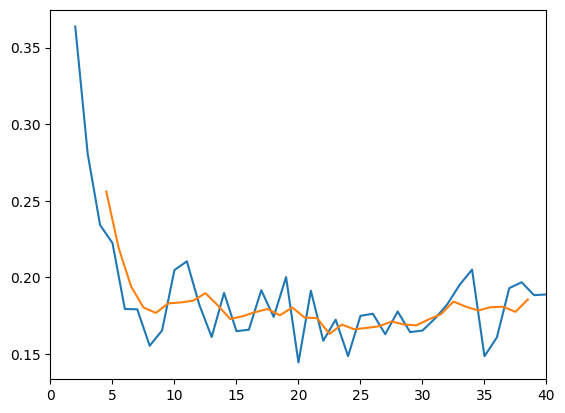

In [99]:
plt.plot(grouped.index, grouped[metrics[mid]])
x, y =running_mean(grouped, 5)
plt.plot(x, y)
plt.xlim([0,40])

# for v in [9, 31, 78]:
#     plt.axvline(v, c='k')
# for v in [15, 31, 78]:
#     plt.axvline(v, c='k')

In [13]:
mid = 0
agg_func = np.mean
grouped = results.groupby('umap__n_components').agg({metrics[mid]: agg_func})
# grouped = results.groupby('pca__n_components').agg({metrics[mid]: agg_func})

In [14]:
def running_mean(grouped, N):
    
    y = grouped[metrics[mid]]
    x = np.array(grouped.index[0:-(N-1)]) + (N/2)
    cumsum = np.cumsum(np.insert(y, 0, 0)) 
    return x, (cumsum[N:] - cumsum[:-N]) / float(N)

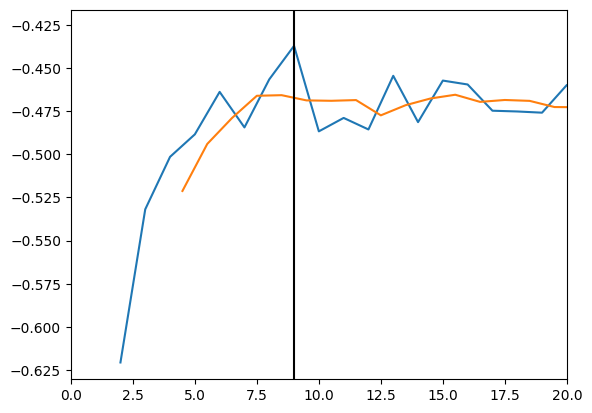

In [179]:
plt.plot(grouped.index, grouped[metrics[mid]])
x, y =running_mean(grouped, 5)
plt.plot(x, y)
plt.xlim([0,20])

for v in [9, 31, 78]:
    plt.axvline(v, c='k')
# for v in [15, 31, 78]:
#     plt.axvline(v, c='k')

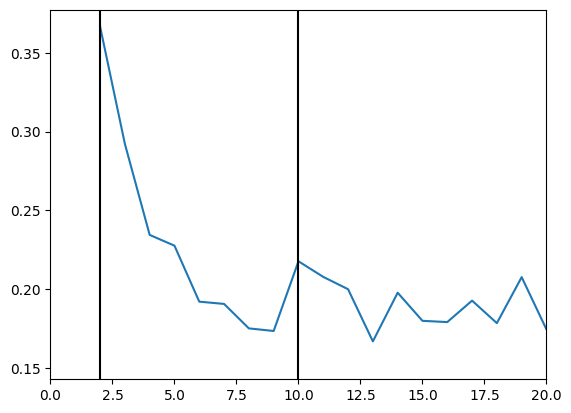

In [15]:
plt.plot(grouped.index, grouped[metrics[mid]])
# x, y =running_mean(grouped, 10)
# plt.plot(x, y)

plt.xlim([0,20])

# for v in [35, 57, 78, 106]:
for v in [2, 10]:
    plt.axvline(v, c='k')


In [100]:
filtered_results = results
# filtered_results = results[results['umap__n_components'] <= 10]
# filtered_results = filtered_results[filtered_results['umap__n_components'] >= 9]

In [101]:
sorted_results = filtered_results.sort_values('silhouette', ascending=False)[['silhouette', 'rv', 'cluster_count', 'labels', 'umap__n_components']]

In [102]:
base_clustering = sorted_results.iloc[0].labels

In [103]:
for i,r in sorted_results.iterrows():
    print(
        "%.4f" % adjusted_mutual_info_score(base_clustering, r.labels),
        "%.4f" % adjusted_mutual_info_score(tessa_clusters.cluster, r.labels)
    )

1.0000 0.3430
0.6584 0.3413
0.6747 0.3467
0.6866 0.3394
0.5589 0.3037
0.5114 0.3942
0.5453 0.3922
0.5446 0.3091
0.5098 0.3953
0.5348 0.3141
0.4933 0.3899
0.5597 0.3109
0.5046 0.3886
0.5241 0.3957
0.4866 0.3907
0.4880 0.3994
0.4887 0.3864
0.5436 0.3180
0.5352 0.3127
0.5526 0.3746
0.5439 0.3183
0.5793 0.3594
0.5857 0.3566
0.5351 0.3132
0.5372 0.3145
0.5373 0.3136
0.5932 0.3622
0.5341 0.3156
0.5202 0.3395
0.5285 0.3855
0.5298 0.3385
0.5667 0.3525
0.5383 0.3152
0.5952 0.3638
0.5428 0.3149
0.5240 0.3434
0.5345 0.3163
0.5504 0.3665
0.5331 0.3158
0.5499 0.3637
0.5256 0.3375
0.5619 0.3683
0.5396 0.3156
0.5336 0.3175
0.5405 0.3132
0.5348 0.3160
0.5219 0.3382
0.5169 0.3363
0.5359 0.3148
0.5338 0.3176
0.4665 0.3839
0.5422 0.3169
0.5223 0.3424
0.5742 0.3522
0.5688 0.3687
0.5734 0.3627
0.4792 0.3695
0.5847 0.3836
0.5759 0.3680
0.5699 0.3831
0.5595 0.3661
0.4542 0.3774
0.5828 0.3486
0.5802 0.3629
0.5799 0.3698
0.5323 0.3142
0.5191 0.3418
0.5548 0.3644
0.5724 0.3669
0.5654 0.3806
0.5388 0.3150
0.4563

In [104]:
sorted_results

,silhouette,rv,cluster_count,labels,umap__n_components
2051,0.410685,-1,4,"[0, 2, 0, 1, 1, 1, 1, 1, 2, 0, 0, 1, 3, 1, 3, ...",2
347,0.396085,-1,4,"[1, 2, 1, 0, 0, 2, 0, 0, 2, 0, 1, 0, 3, 0, 3, ...",2
1305,0.394338,-1,4,"[0, 0, 1, 2, 2, 2, 2, 2, 0, 2, 1, 2, 3, 3, 3, ...",2
1731,0.392768,-1,4,"[2, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 3, 1, 3, ...",2
1206,0.371341,-1,3,"[1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 2, ...",2
...,...,...,...,...,...
575,0.116346,-1,19,"[16, 1, 0, 2, 15, 11, 5, 18, 9, 5, 6, 8, 2, 18...",39
149,0.116226,-1,18,"[1, 15, 1, 6, 7, 2, 7, 2, 10, 7, 10, 6, 9, 2, ...",29
1291,0.116057,-1,16,"[3, 6, 3, 9, 0, 0, 10, 13, 2, 10, 5, 2, 9, 13,...",18
1256,0.112559,-1,19,"[11, 17, 2, 14, 6, 13, 6, 7, 4, 6, 2, 7, 14, 1...",19


In [105]:
len(sorted_results)

504

In [106]:
def ensemble_to_co_association(ensemble):
    if isinstance(ensemble, pd.DataFrame) and 'labels' in ensemble.columns:
        df = pd.DataFrame(ensemble.labels)
        df = pd.DataFrame(df['labels'].to_list()).transpose()
    else:
        df = pd.DataFrame(ensemble).transpose()

    N = len(df)

    co_association_matrix = np.zeros([N, N])
    n_estimators = len(ensemble)

    for ri, row in df.iterrows():

        if ri%500 == 0:
            print(ri)

        compare = df.loc[ri + 1:]
        if IGNORE_LABEL is not None:
            shared_counts = ((row == compare) * (row != -1) * (compare != -1)).sum(axis=1)
        else:
            shared_counts = (row == compare).sum(axis=1)

        co_association_matrix[ri, ri + 1:] = shared_counts / n_estimators

    return co_association_matrix


def similarity_to_linkage(similarity_matrix, plot_flag=True, method=LINKAGE_METHOD):
    distance_matrix = 1 - similarity_matrix
    linkage_matrix = hierarchy.linkage(distance_matrix, method=method)

    if plot_flag:
        dendro_row = hierarchy.dendrogram(linkage_matrix, orientation='left')

    return linkage_matrix

In [107]:
ensemble = sorted_results

In [108]:
final_co_association_matrix = ensemble_to_co_association(ensemble)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


In [114]:
final_linkage_matrix = similarity_to_linkage(final_co_association_matrix, plot_flag=True)

KeyboardInterrupt: 

In [219]:
final_clusters = hierarchy.fcluster(final_linkage_matrix, t=12, criterion='distance')
# final_clusters = hierarchy.fcluster(final_linkage_matrix, t=7, criterion='maxclust')
# final_clusters = ensemble_outputs[0]['final_clusters'][6]
# final_clusters = ensemble_outputs_new[1]['final_clusters'][5]

In [115]:
# vals = np.unique(cas_final_clusters, return_counts=True)
vals = np.unique(sc.labels_, return_counts=True)
# vals = np.unique(final_clusters, return_counts=True)
vals

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([683, 987, 816, 442, 571, 993, 791, 748]))

<BarContainer object of 8 artists>

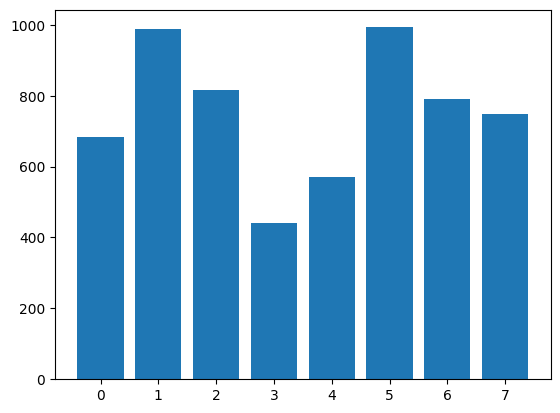

In [136]:
plt.bar(vals[0], vals[1])

In [25]:
G = nx.from_numpy_array(final_co_association_matrix)

In [26]:
type(G)

networkx.classes.graph.Graph

In [27]:
G.get_edge_data(0, 1)

{'weight': 0.04}

In [28]:
partition = nx.community.greedy_modularity_communities(G, weight='weight')

In [33]:
def partition_to_labels(part, index_df=symptom_data):
    
    c_labels = {c:ci for ci,com in enumerate(part) for c in com}
    return np.array([c_labels[i] for i in index_df.index])

In [34]:
final_clusters = partition_to_labels(partition)

KeyError: 6031

In [36]:
len(partition)

2

In [155]:
nc = 8

In [156]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(nc, affinity='precomputed', n_init=100, random_state=SEED)
sc.fit(final_co_association_matrix)
np.unique(sc.labels_, return_counts=True)

/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([683, 987, 816, 442, 571, 993, 791, 748]))

In [157]:
adjusted_mutual_info_score(tessa_clusters.cluster, sc.labels_)

0.4015499935726745

In [170]:
# final_clusters = results.iloc[np.random.randint(0, len(results))].labels
final_clusters = results[results.cluster_count==19].iloc[0].labels

In [158]:
# final_clusters = sorted_results.loc[552].labels
# final_clusters = sc.labels_

In [171]:
fc = pd.DataFrame(index=symptom_data.index)
fc['cluster'] = final_clusters

In [172]:
# fc.to_csv('../clusterings/chris/umap_kmeans_ensemble_up_to_40_components_inclusion_any_n_cluster_%d.csv' % nc)
fc.to_csv('../clusterings/chris/temp_test.csv')

In [29]:
import scipy
from scipy.sparse import csgraph
# from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

In [36]:
final_co_association_matrix = ensemble_outputs[0]['final_co_association_matrix']

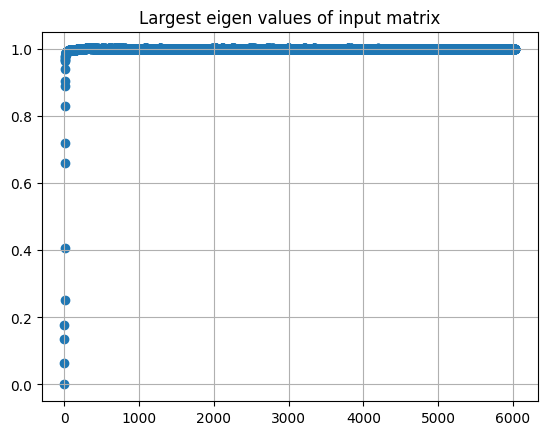

In [39]:
adj_mat = final_co_association_matrix + final_co_association_matrix.transpose()
nb_clusters, eigenvalues, eigenvectors = eigenDecomposition(adj_mat)

/tmp/ipykernel_5899/3594633525.py:48: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 10000])


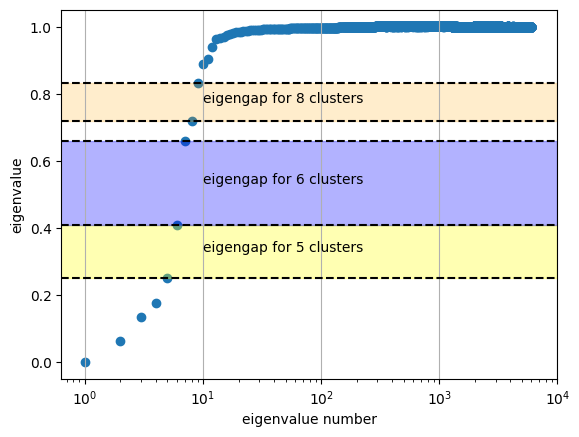

In [62]:
# plt.title('Largest eigen values of input matrix')
plt.scatter(np.arange(len(eigenvalues)) + 1, eigenvalues)
plt.grid(axis='x')
plt.xscale('log')
plt.fill_between(
    x=[0, 10000], 
    y1=eigenvalues[4],
    y2=eigenvalues[5],
    alpha=0.3,
    color='yellow'
)

plt.fill_between(
    x=[0, 10000], 
    y1=eigenvalues[5],
    y2=eigenvalues[6],
    alpha=0.3,
    color='blue'
)

plt.fill_between(
    x=[0, 10000], 
    y1=eigenvalues[7],
    y2=eigenvalues[8],
    alpha=0.2,
    color='orange'
)
plt.axhline(eigenvalues[4], c='k', linestyle='--')
plt.axhline(eigenvalues[5], c='k', linestyle='--')
plt.axhline(eigenvalues[6], c='k', linestyle='--')
plt.axhline(eigenvalues[7], c='k', linestyle='--')
plt.axhline(eigenvalues[8], c='k', linestyle='--')
plt.text(
    x=10, 
    y=(eigenvalues[4]+eigenvalues[5])/2,
    s='eigengap for 5 clusters'
)
plt.text(
    x=10, 
    y=(eigenvalues[5]+eigenvalues[6])/2,
    s='eigengap for 6 clusters'
)
plt.text(
    x=10, 
    y=(eigenvalues[7]+eigenvalues[8])/2,
    s='eigengap for 8 clusters'
)
plt.xlim([0, 10000])

plt.xlabel('eigenvalue number')
plt.ylabel('eigenvalue');

/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5398: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5399: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5402: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
/home/rustybilges/Documents/Work/PLRC/PLR/Chris/venv/lib/python3.8/site-packages/matplotlib/axes/_axes.py:5404: ComplexWarning: Casting complex va

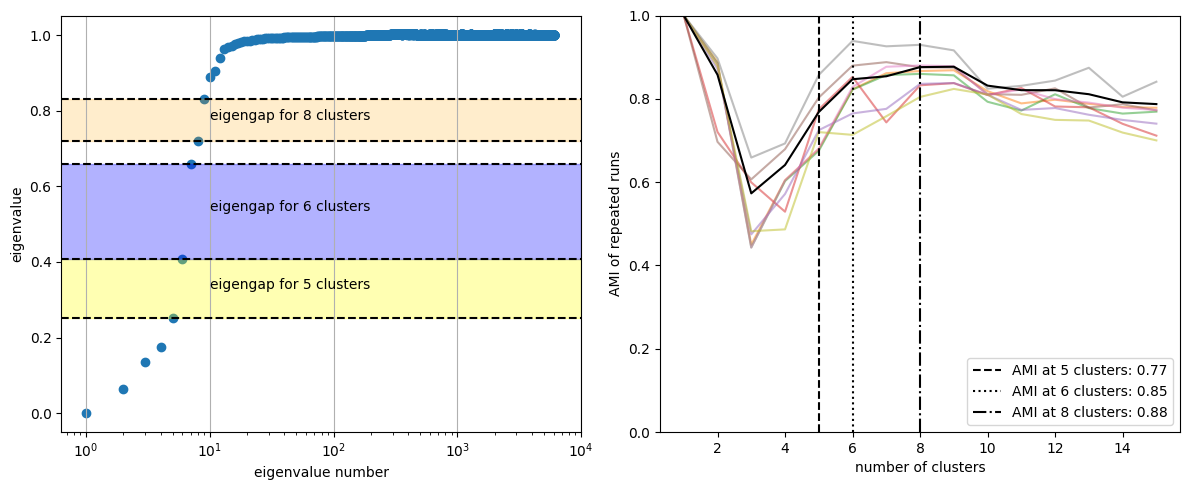

In [65]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# plt.title('Largest eigen values of input matrix')
plt.scatter(np.arange(len(eigenvalues)) + 1, eigenvalues)
plt.grid(axis='x')
plt.xscale('log')
plt.fill_between(
    x=[0, 10000], 
    y1=eigenvalues[4],
    y2=eigenvalues[5],
    alpha=0.3,
    color='yellow'
)

plt.fill_between(
    x=[0, 10000], 
    y1=eigenvalues[5],
    y2=eigenvalues[6],
    alpha=0.3,
    color='blue'
)

plt.fill_between(
    x=[0, 10000], 
    y1=eigenvalues[7],
    y2=eigenvalues[8],
    alpha=0.2,
    color='orange'
)
plt.axhline(eigenvalues[4], c='k', linestyle='--')
plt.axhline(eigenvalues[5], c='k', linestyle='--')
plt.axhline(eigenvalues[6], c='k', linestyle='--')
plt.axhline(eigenvalues[7], c='k', linestyle='--')
plt.axhline(eigenvalues[8], c='k', linestyle='--')
plt.text(
    x=10, 
    y=(eigenvalues[4]+eigenvalues[5])/2,
    s='eigengap for 5 clusters'
)
plt.text(
    x=10, 
    y=(eigenvalues[5]+eigenvalues[6])/2,
    s='eigengap for 6 clusters'
)
plt.text(
    x=10, 
    y=(eigenvalues[7]+eigenvalues[8])/2,
    s='eigengap for 8 clusters'
)
plt.xlim([0, 10000])

plt.xlabel('eigenvalue number')
plt.ylabel('eigenvalue');


plt.subplot(1, 2, 2)
base_E = 'run_1_kmeans_JC_50_0.5'

E = [
    'run_1_kmeans_JC_50_0.5'
]

with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % base_E, 'rb') as infile:
        _base_e = pk.load(infile)

for ei, e in enumerate(E):
    with open('./fern_ensemble_outputs_spectral/%s/ensemble_outputs.pickle' % e, 'rb') as infile:
        _ensemble_outputs = pk.load(infile)

#     plt.title(e)
    M=[]
    for i in range(len(_base_e)):
#     for i in range(10):
        if len(_ensemble_outputs) > i+1:
            ami = [
                adjusted_mutual_info_score(
                    _base_e[0]['final_clusters'][j],
                    _ensemble_outputs[i]['final_clusters'][j]
                )
                for j in range(15)
            ]

            plt.plot(
                [i+1 for i in range(15)],
                ami,
                alpha=0.5
            )
            M.append(ami)
        
#     plt.axhline(np.mean(M), c='k')
    plt.plot([i+1 for i in range(15)], np.array(M).mean(axis=0), c='k')
    plt.xlabel('number of clusters')
    plt.ylabel('AMI of repeated runs')
    plt.ylim([0,1])
    plt.axvline(5, linestyle='--', c='k', label='AMI at 5 clusters: %.2f' % np.array(M).mean(axis=0)[4])
    plt.axvline(6, linestyle=':', c='k', label='AMI at 6 clusters: %.2f' % np.array(M).mean(axis=0)[5])
    plt.axvline(8, linestyle='-.', c='k', label='AMI at 8 clusters: %.2f' % np.array(M).mean(axis=0)[7])
#     plt.axhline(np.array(M).mean(axis=0)[7], linestyle='--', c='k')
        
plt.legend()
plt.tight_layout()

In [9]:
# chris_clusters = pd.read_csv('../clusterings/chris/parametric_umap_n_clusters_7.csv', index_col=0)
chris_clusters = pd.read_csv('../clusterings/chris/lowdim_spectral_ensemble_50_kmeans_joint_criterion_alpha_0.5_n_clusters_8.csv', index_col=0)

For n_clusters = 8 The average silhouette_score is : 0.0008441192330815102


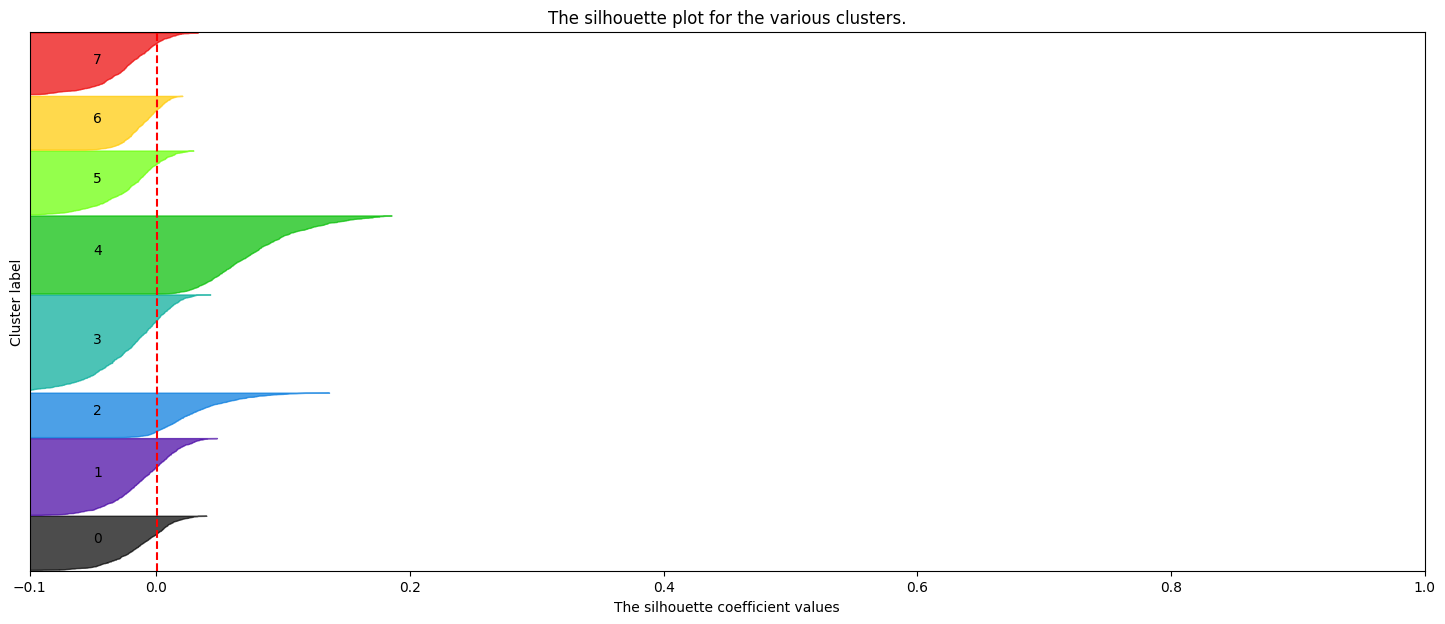

In [10]:
X = symptom_data
n_clusters = 8
cluster_labels = chris_clusters.cluster

fig = plt.figure()
ax1 = plt.gca()
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        -0.1,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]);



In [11]:
with open('./fern_ensemble_outputs_spectral/run_1_kmeans_JC_50_0.5/ensemble_outputs.pickle', 'rb') as infile:
    ensemble_outputs = pk.load(infile)

In [28]:
ensemble_outputs[0]['final_co_association_matrix']

array([[0.  , 0.  , 0.68, ..., 0.  , 0.02, 0.48],
       [0.  , 0.  , 0.  , ..., 0.86, 0.  , 0.3 ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.2 , 0.16],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.18],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [12]:
final_clusters = ensemble_outputs[0]['final_clusters'][2]

For n_clusters = 3 The average silhouette_score is : 0.008608274167770404
For n_clusters = 4 The average silhouette_score is : 0.002505922687257707
For n_clusters = 5 The average silhouette_score is : 0.0034745009526597407
For n_clusters = 6 The average silhouette_score is : 0.000157904938601985
For n_clusters = 7 The average silhouette_score is : 0.0007017196987830508
For n_clusters = 8 The average silhouette_score is : 0.0008441192330815102
For n_clusters = 9 The average silhouette_score is : -0.0008179129782547928
For n_clusters = 10 The average silhouette_score is : -0.002795847249115432
For n_clusters = 11 The average silhouette_score is : -0.004027747878102415
For n_clusters = 12 The average silhouette_score is : -0.0040611749137346295
For n_clusters = 13 The average silhouette_score is : -0.004670156239927454
For n_clusters = 14 The average silhouette_score is : -0.006208910543648514


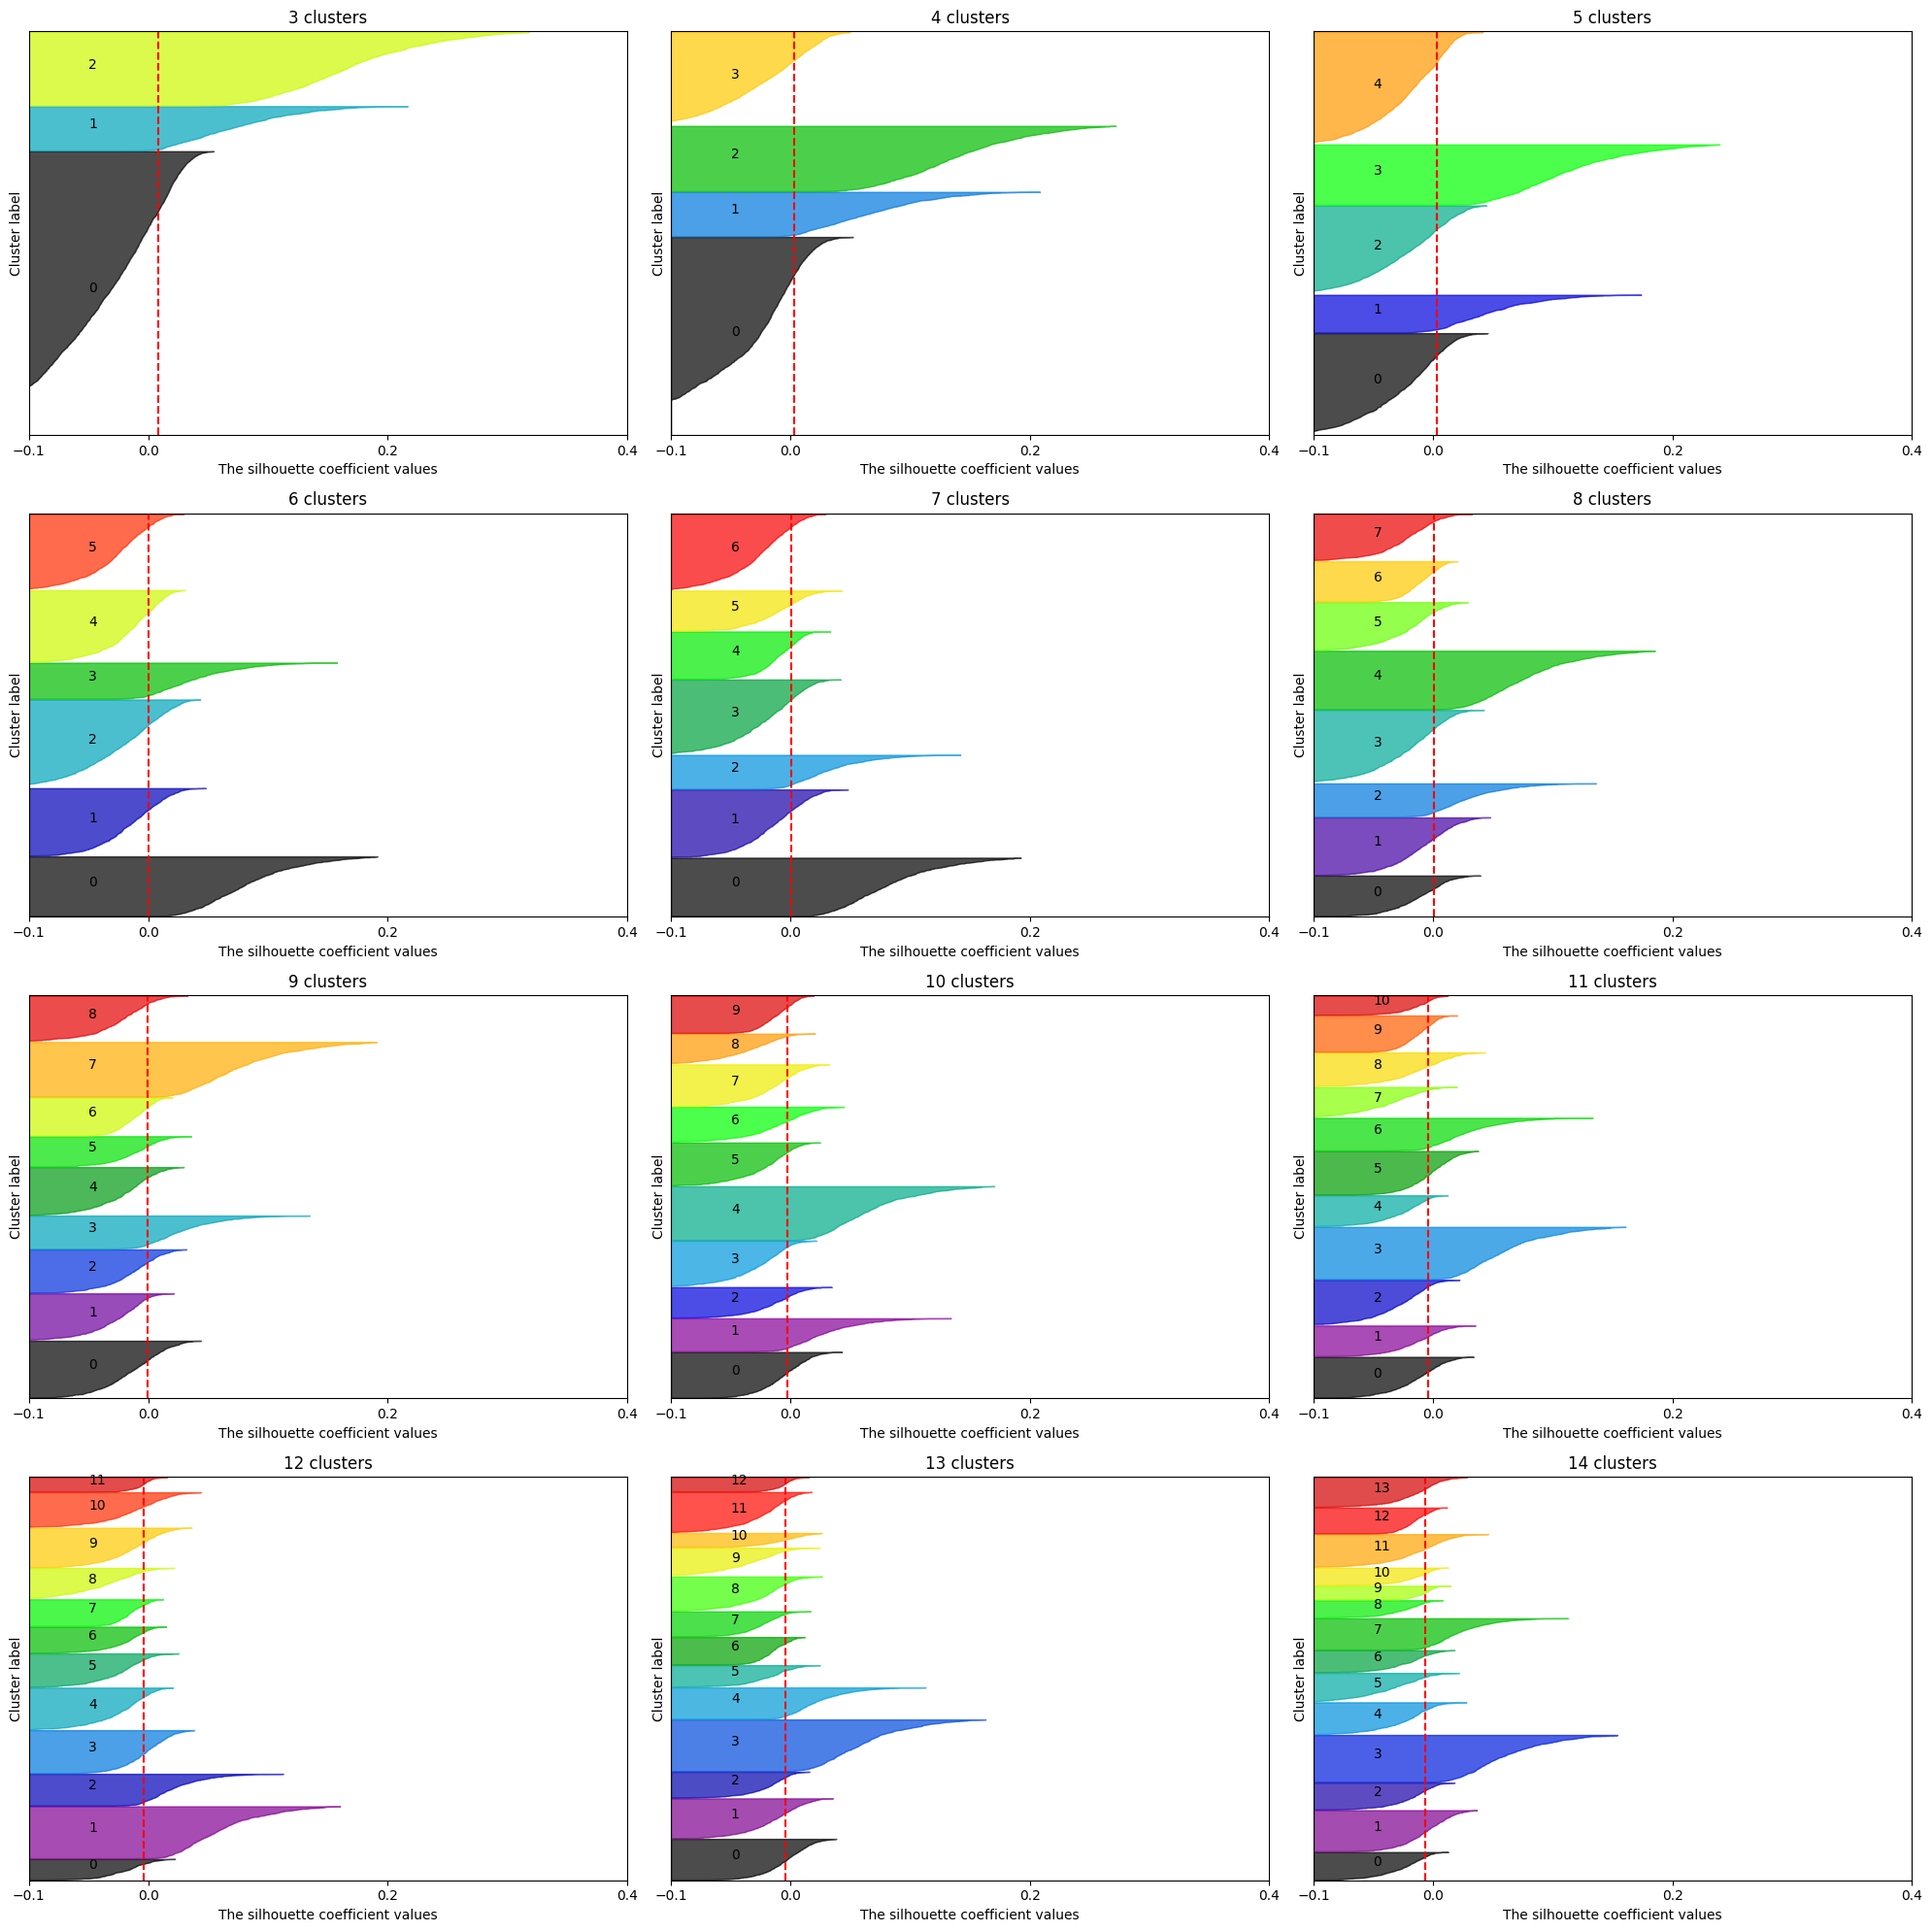

In [32]:
sil = {}
sil_var = {}
X = symptom_data
plt.figure(figsize=(20,20))

for i in range(2, 14):
    
    n_clusters = i+1
    cluster_labels = ensemble_outputs[0]['final_clusters'][i]

#     plt.figure()
#     ax1 = plt.gca()
#     fig.set_size_inches(18, 7)
    ax1 = plt.subplot(4,3,i-1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 0.4])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            -0.1,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("%d clusters" % n_clusters)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4]) #, 0.6, 0.8, 1]);
    
    sil[i] = silhouette_avg
    sil_var[i] = np.var(sample_silhouette_values)

plt.tight_layout();

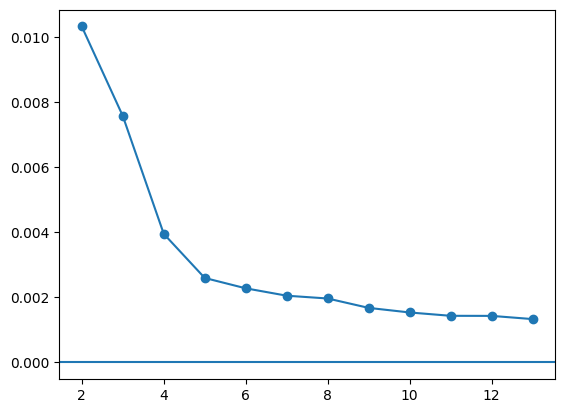

In [33]:
plt.plot(sil_var.keys(), sil_var.values(), '-o')
plt.axhline(0)

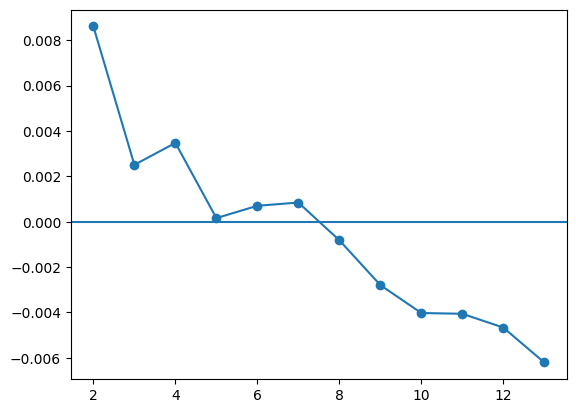

In [24]:
plt.plot(sil.keys(), sil.values(), '-o')
plt.axhline(0)

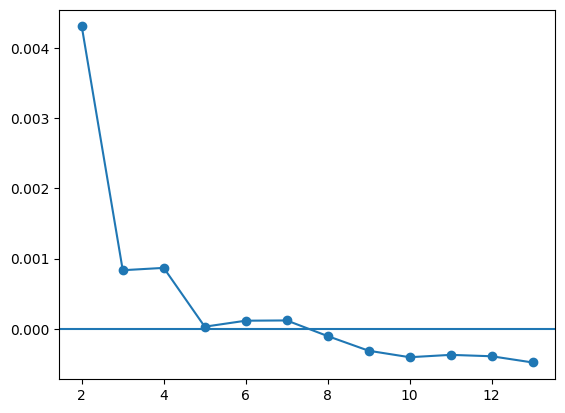

In [26]:
sil_norm = {
    key: val/ key
    for key, val in sil.items()
}
plt.plot(sil_norm.keys(), sil_norm.values(), '-o')
plt.axhline(0)

In [121]:
from sklearn.decomposition import PCA

In [125]:
pca = PCA(n_components=100)

In [126]:
pca.fit(symptom_data)

PCA(n_components=100)

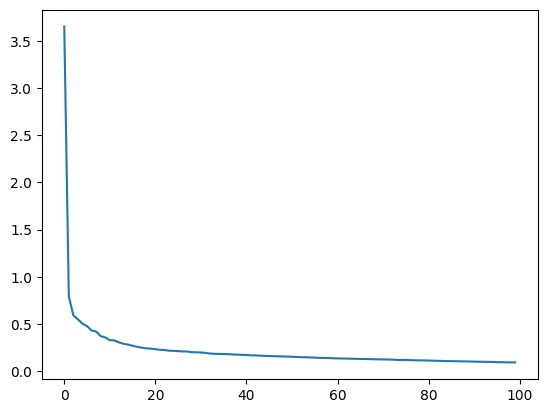

In [128]:
plt.plot(pca.explained_variance_)

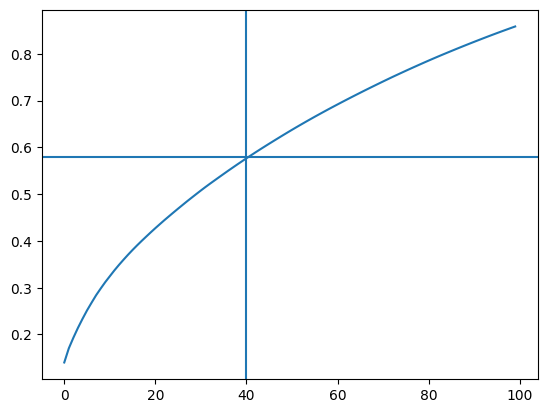

In [135]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.58)
plt.axvline(40)

In [195]:
wc = 4

In [196]:
dc = 2

In [197]:
ohe = np.zeros(wc*dc)

In [198]:
ohe

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [199]:
wdid = [0, 1, 0, 1]

In [201]:
for wi, id in enumerate(wdid):
    print(wi, id)
    ohe[wi*dc + id] = 1

0 0
1 1
2 0
3 1


In [202]:
ohe

array([1., 0., 0., 1., 1., 0., 1., 1.])

In [193]:

99*(100-1) + 10

9811

In [194]:
11*99 + 4

1093